In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<hr style="border-width:2px;border-color:#75DFC1">
<h1 style = "text-align:center" > UniGe Cosmo Machine Learning </h1> 
<h2 style = "text-align:center"> Tutorial 2 - ML </h2> 
<h3 style = "text-align:center"> 21.02.2020 - Michele </h3> 
<hr style="border-width:2px;border-color:#75DFC1">


> This tutotial deals with classification problems and compares different algorithms. We will **distringuish stars from QSOs in the SDSS catalogue** using photometric data. 

> Summary:
* Decision Trees , Random Forests
* Hyperparameter tuning, grid search, pipelines
* Custom evaluation metrics
* Support Vector Machines
* k Nearest Neighbors



<img src="imgs/MLworkflow.png">

> Goals:
* Learn how to apply most widely used ML algotithms with sklearn
* More advanced: change evaluation metric, pipelines, hyperparameter tuning


> Packages and resources:
* This tutorial is based on **scikit-learn**. [**scikit-learn**](https://scikit-learn.org/stable/) is an open source, user-friendly machine learning library. It has an extensive documentation as well as tutorials. Check that out ;)


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns#; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

a4_dims = (11.7, 8.27)

<hr style="border-width:2px;border-color:#75DFC1">
<h2 style = "text-align:center"> Data </h2> 
<hr style="border-width:2px;border-color:#75DFC1">

Fetch data

In [3]:
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
data = data[::5]

In [4]:
data.shape

(10000,)

Numpy VS Pandas

In [5]:
type(data)

numpy.ndarray

In [6]:
data[:5]

array([(19.24375, 17.73302, 16.93751, 16.48981, 16.14938, 'GALAXY', 0.04876398, 6.728162e-06),
       (18.82606, 17.35682, 16.61417, 16.22543, 15.94271, 'GALAXY', 0.05037882, 1.607314e-05),
       (18.54282, 17.39553, 16.93441, 16.64284, 16.41668, 'GALAXY', 0.03575721, 5.839199e-06),
       (18.72188, 17.71997, 17.31576, 17.01017, 16.86703, 'GALAXY', 0.1015913 , 6.286412e-06),
       (19.16156, 17.56087, 16.91489, 16.52665, 16.27669, 'GALAXY', 0.06219114, 1.305583e-05)],
      dtype=[('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('specClass', '<U6'), ('redshift', '<f8'), ('redshift_err', '<f8')])

In [7]:
colnames = list(data.dtype.fields.keys())
colnames

['u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err']

In [8]:
df = pd.DataFrame(data , columns=colnames)

In [9]:
df.head()

u         g         r         i         z specClass  redshift  \
0  19.24375  17.73302  16.93751  16.48981  16.14938    GALAXY  0.048764   
1  18.82606  17.35682  16.61417  16.22543  15.94271    GALAXY  0.050379   
2  18.54282  17.39553  16.93441  16.64284  16.41668    GALAXY  0.035757   
3  18.72188  17.71997  17.31576  17.01017  16.86703    GALAXY  0.101591   
4  19.16156  17.56087  16.91489  16.52665  16.27669    GALAXY  0.062191   

   redshift_err  
0      0.000007  
1      0.000016  
2      0.000006  
3      0.000006  
4      0.000013

In [10]:
df['u-g'] = df['u']-df['g']
df['g-r'] = df['g']-df['r']
df['r-i'] = df['r']-df['i']
df['i-z'] = df['i']-df['z']

In [11]:
df['specClass_label'] = pd.get_dummies(df['specClass'],prefix='specClass')['specClass_GALAXY']

In [12]:
df.head()

u         g         r         i         z specClass  redshift  \
0  19.24375  17.73302  16.93751  16.48981  16.14938    GALAXY  0.048764   
1  18.82606  17.35682  16.61417  16.22543  15.94271    GALAXY  0.050379   
2  18.54282  17.39553  16.93441  16.64284  16.41668    GALAXY  0.035757   
3  18.72188  17.71997  17.31576  17.01017  16.86703    GALAXY  0.101591   
4  19.16156  17.56087  16.91489  16.52665  16.27669    GALAXY  0.062191   

   redshift_err      u-g      g-r      r-i      i-z  specClass_label  
0      0.000007  1.51073  0.79551  0.44770  0.34043                1  
1      0.000016  1.46924  0.74265  0.38874  0.28272                1  
2      0.000006  1.14729  0.46112  0.29157  0.22616                1  
3      0.000006  1.00191  0.40421  0.30559  0.14314                1  
4      0.000013  1.60069  0.64598  0.38824  0.24996                1

In [ ]:

plt.figure(figsize=a4_dims)
ax = sns.pairplot( df,
                   vars=['u-g', 'g-r', 'r-i', 'i-z'],
                     hue='specClass' #, style=hue
                     );


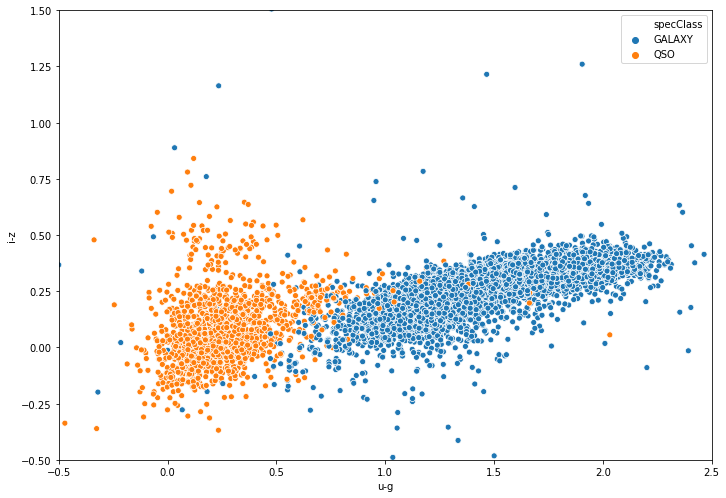

In [13]:
plt.figure(figsize=a4_dims)
ax = sns.scatterplot( x='u-g',y='i-z', data=df,
                   #vars=['u-g', 'g-r', 'r-i', 'i-z'],
                     hue='specClass' #, style=hue
                     );

ax.set_xlim(-0.5, 2.5);
ax.set_ylim(-0.5, 1.5);

In [14]:
X_all, y_all = df[['u', 'g', 'r', 'i', 'z', 'u-g', 'g-r', 'r-i', 'i-z']], df['specClass_label']

### Split into train and test set

In [15]:
from sklearn.model_selection import train_test_split 

In [16]:
# More advanced: use k-fold or multiple train-test split !


X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size = 0.25, \
                                                   stratify = y_all )

# Note: use stratify to keep proportion of output classes when splitting ! 
# Super important if you have unmbalanced classes
# When doing k-fold cross validation, check Stratified k-fold



<hr style="border-width:2px;border-color:#75DFC1">
<h2 style = "text-align:center"> General setup </h2> 
<hr style="border-width:2px;border-color:#75DFC1">

In [17]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.model_selection import cross_val_score


def score_res(clf, test_X, test_y, X, y, myCV=10):
    y_pred = clf.predict(test_X)
    acc = accuracy_score(y_pred, test_y)
    scores = cross_val_score(clf, X, y, cv=myCV)
    meanAcc=scores.mean()
    print('Accuracy from 1 test set: %s \n' %acc)
    print (classification_report(test_y, y_pred))
    print ('Confusion_matrix:')
    print (confusion_matrix(test_y, y_pred))
    print('\n k-fold cross validation with %s folds: ' %myCV)
    print (scores)
    print("\n Accuracy: %0.2f (+/- %0.2f)\n" % (meanAcc, scores.std() * 2))
    #scores1=SKFold(clf,all_X,all_y,myCV)
 
    #y_pred=clf.predict(test_X)
    #mae=mean_absolute_error(test_y, y_pred)
    #print("Mean absolute error: %s" %mae)
    return meanAcc

In [34]:
def plot_decision_regions(X, y, classifier, resolution=0.02, eps=0.1):

    if isinstance(X,pd.DataFrame):
        X=X.to_numpy()
        y=y.to_numpy()

    from matplotlib.colors import ListedColormap
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')

    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    x2_min, x2_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                     np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.figure(figsize=a4_dims)
    plt.contourf(xx1, xx2, Z, alpha=0.2)#, cmap=cmap)
    #plt.xlim(xx1.min(), xx1.max())
    #plt.ylim(xx2.min(), xx2.max())
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        sns.scatterplot(x=X[y == cl, 0], y=X[y == cl, 1])
                #alpha=0.8, #c=cmap(idx),
                #marker=markers[idx], label=cl)
    plt.xlim(-0.5, 2.5);
    plt.ylim(-1, 1.5);

<hr style="border-width:2px;border-color:#75DFC1">
<h2 style = "text-align:center"> Basic ML w. Decision Trees </h2> 
<hr style="border-width:2px;border-color:#75DFC1">

 http://scikit-learn.org/stable/modules/tree.html
 
 Reminder: basic usage of sklearn
 
 > *  Split into train/test set:
```python 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)```

> * Train your model
```python 
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)```

> * Evaluate
```python 
logreg.score(X_test[c], y_test)```
 gives accuracy. For other metrics:
```python 
from sklearn.metrics import precision_score, recall_score, f1_score
y_pred = logreg.predict(X_test)
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
```

Slightly better: evaluate with k-fold cross validation. This is what the function score_res() does (with accuracy as a metric)

#### Blind application

In [19]:
from sklearn import tree

DTclf = tree.DecisionTreeClassifier()
DTclf=DTclf.fit(X_train_all, y_train_all)

acc_dectree=score_res(DTclf, X_test_all, y_test_all, X_all, y_all, 10)



Accuracy from 1 test set: 0.9744 

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       367
           1       0.99      0.98      0.98      2133

    accuracy                           0.97      2500
   macro avg       0.95      0.95      0.95      2500
weighted avg       0.97      0.97      0.97      2500

Confusion_matrix:
[[ 339   28]
 [  36 2097]]

 k-fold cross validation with 10 folds: 
[0.97402597 0.97702298 0.97702298 0.976      0.967      0.982
 0.982      0.97397397 0.98198198 0.98098098]

 Accuracy: 0.98 (+/- 0.01)



> With a decision tree, we can visualise the hierarchical partition of the data using [**Graphviz**](http://www.graphviz.org).

In [20]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

/Users/Michi/miniconda3/envs/snakes/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


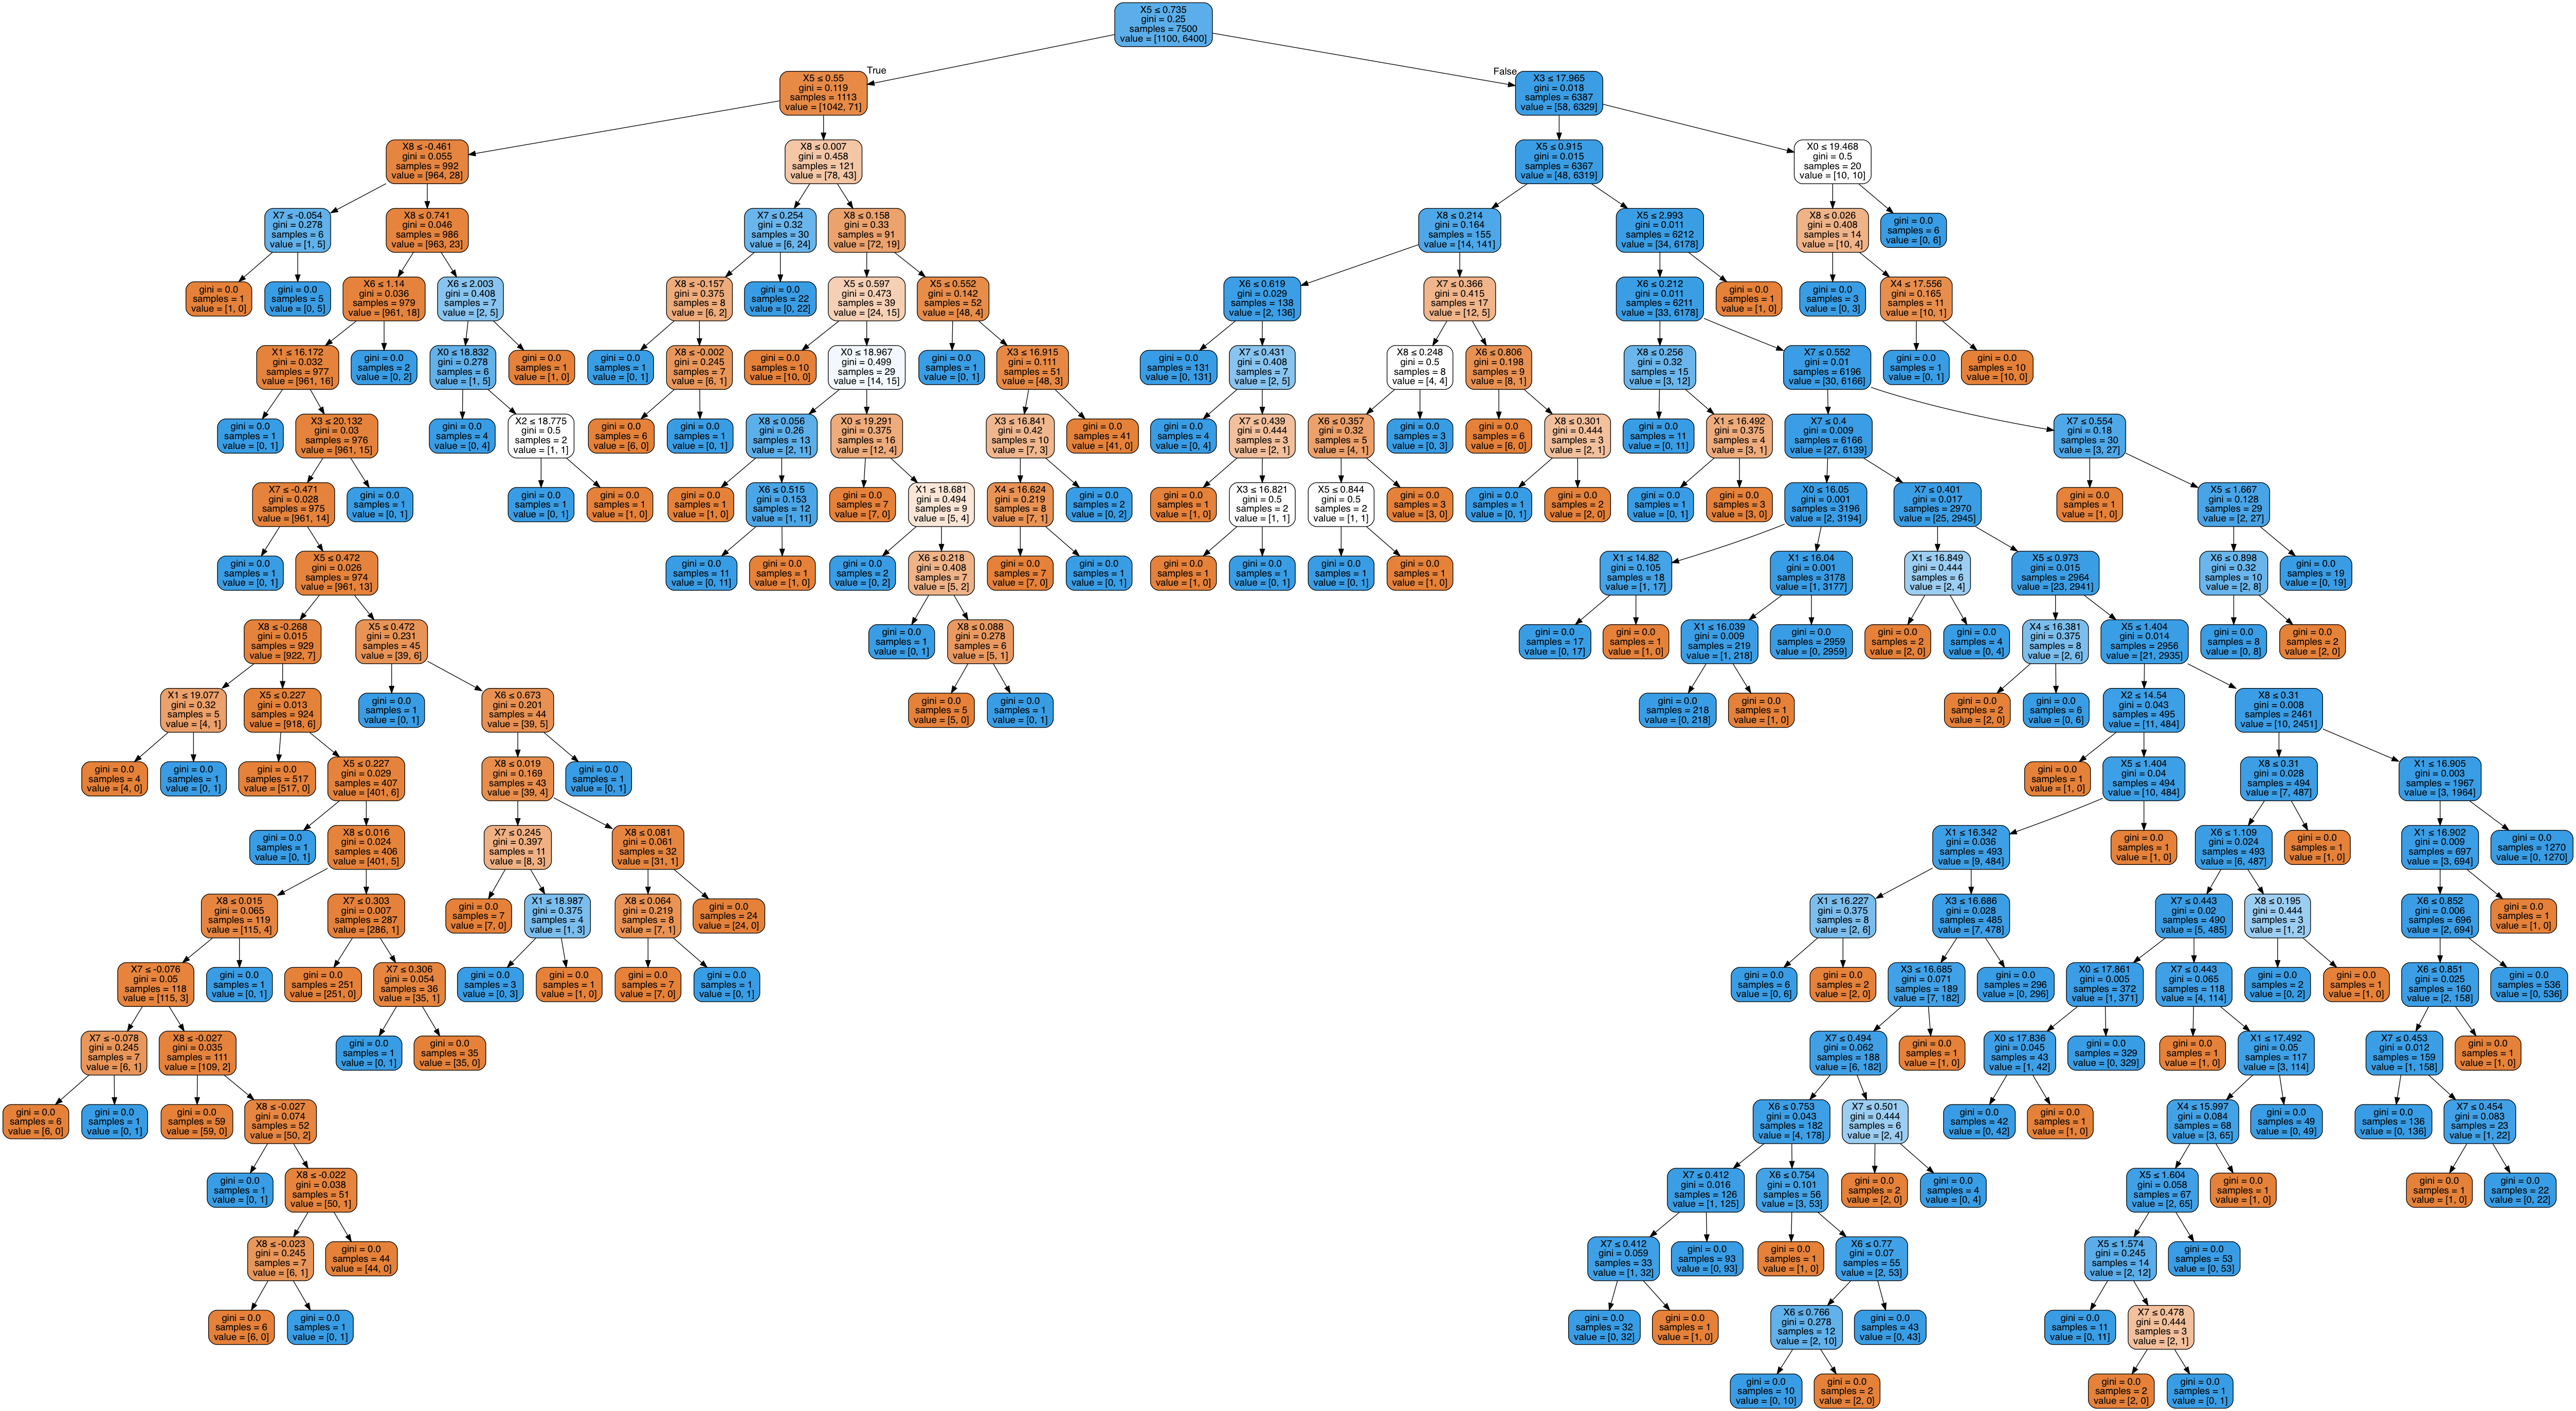

In [21]:
dot_data = StringIO()
export_graphviz(DTclf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

> <span style="color:#09b038; text-decoration : underline"> Question :</span><br>  
    
* Do you understand? If so, can you explain it to me? If not, what's the problem (in ML language)?

> This is a typical example of Decision Trees easily **overfitting**.  As can be seen, to many subcases for a siple problem (remember the scatterplots above? )

> Fortunately, Decision Trees are **white boxes**: we can compute and visualise *feature importance* to see what feature have larger impact on the final decision

0.9744


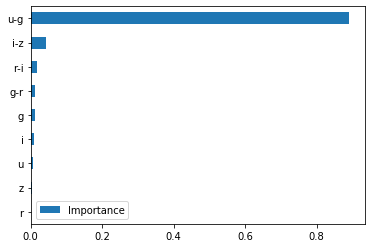

In [22]:
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[:].plot( kind = 'barh' )
    print (model.score( X , y ))
    return imp

myImp=plot_model_var_imp(DTclf,X_test_all,y_test_all)

#### Regularization #1: use less features

In [24]:
X, y = df[['u-g', 'i-z']] , df['specClass_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, \
                                                   stratify = y )

In [25]:
DTclf = tree.DecisionTreeClassifier( )
DTclf=DTclf.fit(X_train, y_train)

acc_dectree=score_res(DTclf, X_test, y_test, X, y, 10)


Accuracy from 1 test set: 0.9716 

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       367
           1       0.98      0.98      0.98      2133

    accuracy                           0.97      2500
   macro avg       0.94      0.94      0.94      2500
weighted avg       0.97      0.97      0.97      2500

Confusion_matrix:
[[ 331   36]
 [  35 2098]]

 k-fold cross validation with 10 folds: 
[0.97402597 0.97602398 0.98101898 0.978      0.963      0.98
 0.983      0.97097097 0.98098098 0.97097097]

 Accuracy: 0.98 (+/- 0.01)



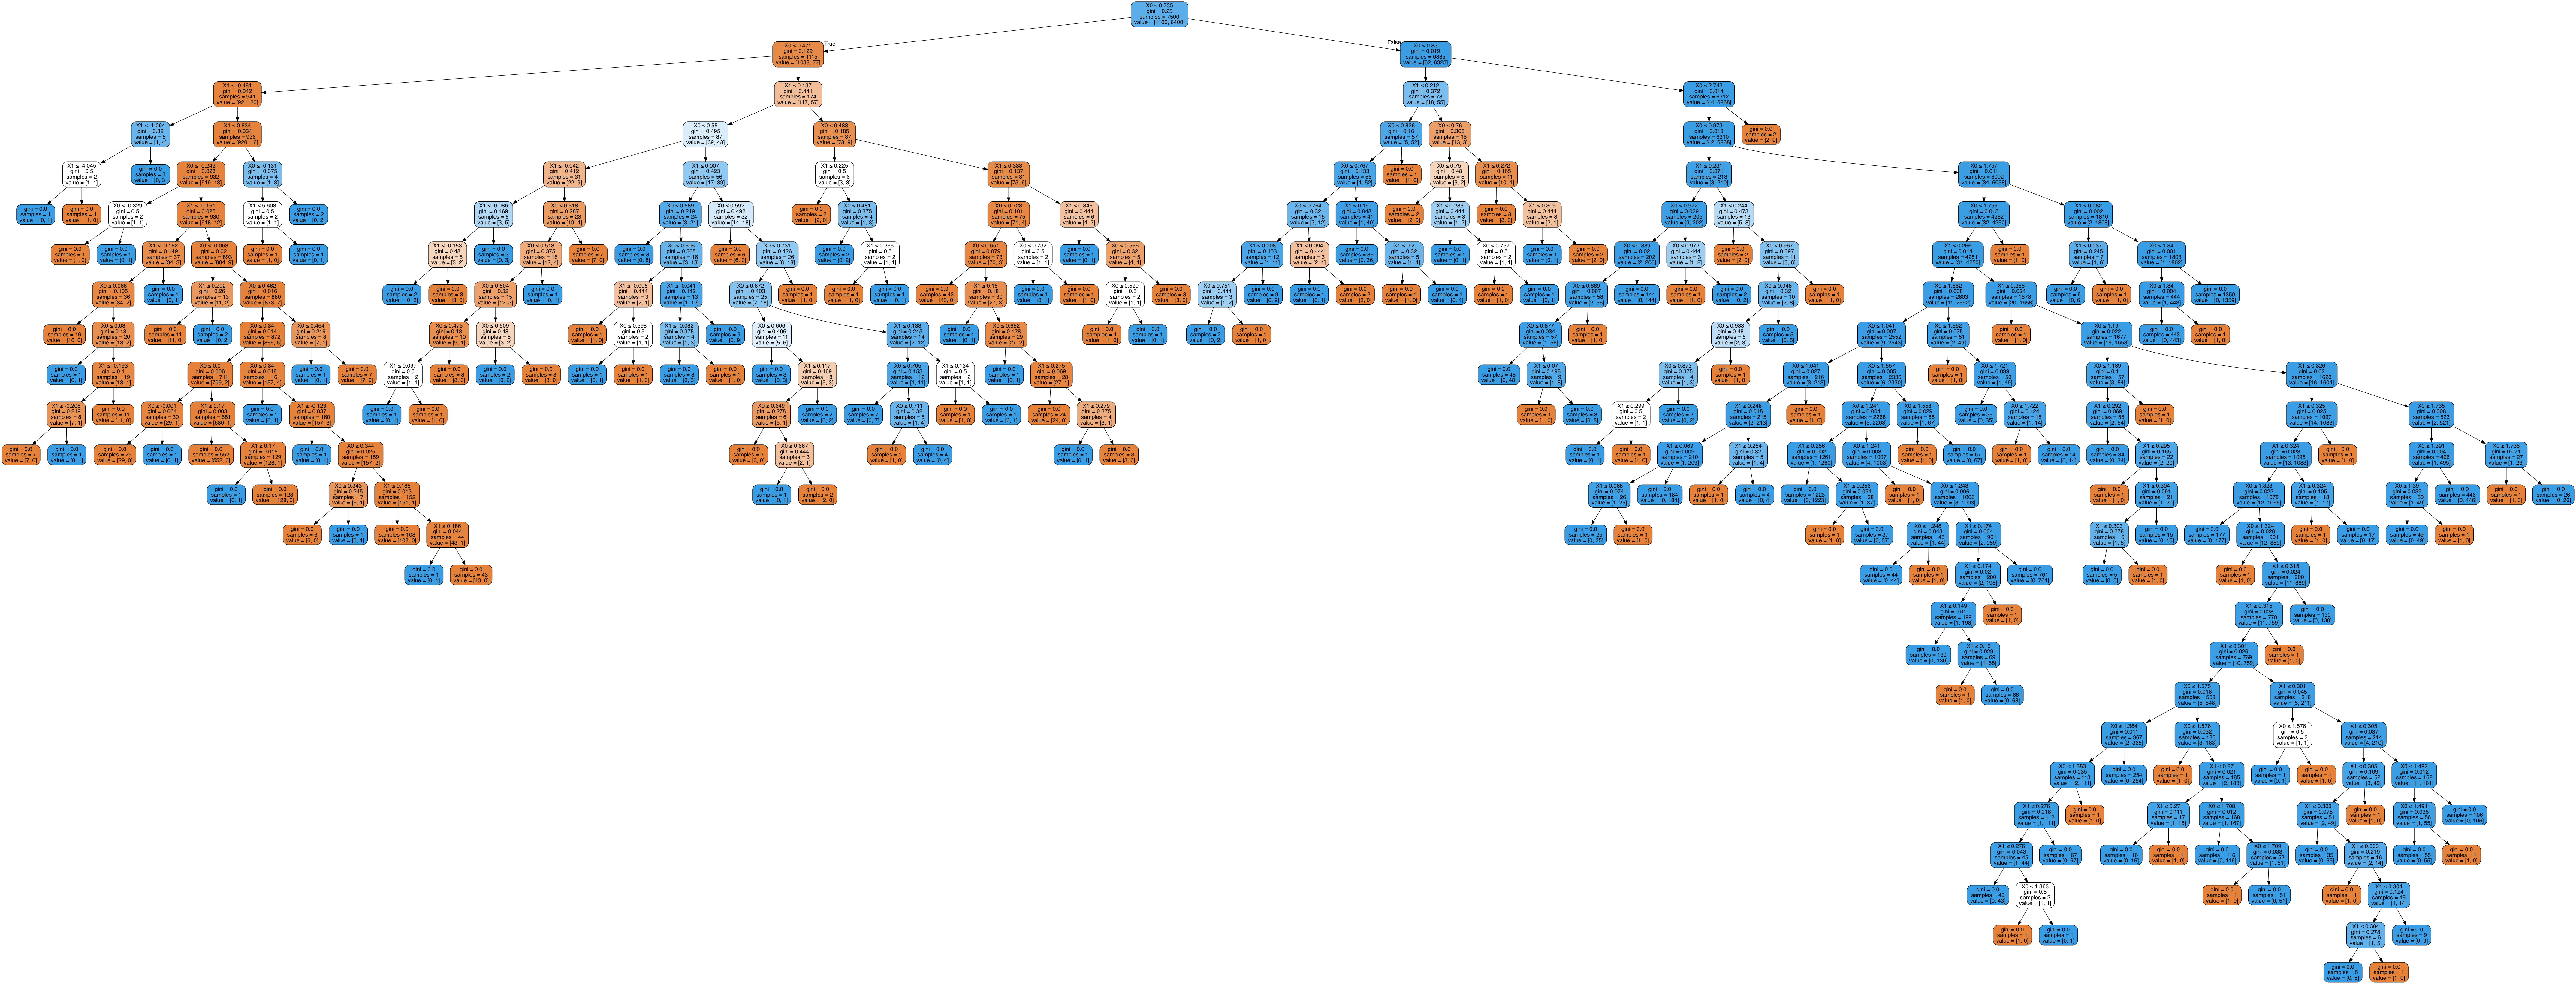

In [26]:
dot_data = StringIO()
export_graphviz(DTclf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

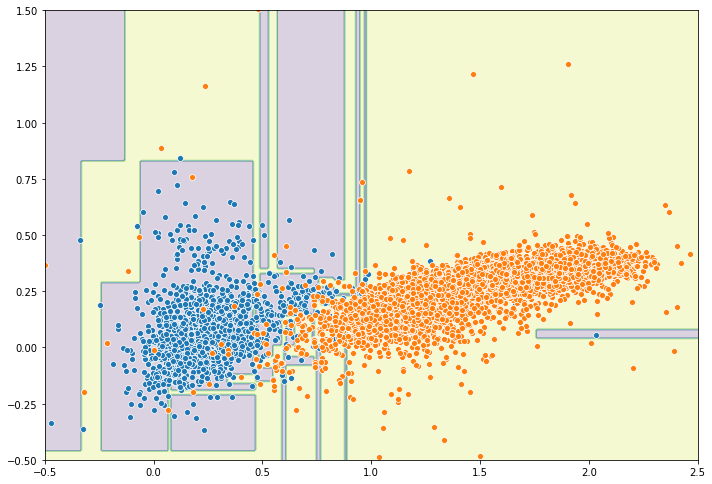

In [27]:
plot_decision_regions(X, y, DTclf, resolution=0.01, eps=0.1)

> The above decision regions are the perfect example of **overfitting**. Check : see what the performance on the *training set* is

In [28]:
score_res(DTclf, X_train, y_train, X, y, 10)

Accuracy from 1 test set: 1.0 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1100
           1       1.00      1.00      1.00      6400

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500

Confusion_matrix:
[[1100    0]
 [   0 6400]]

 k-fold cross validation with 10 folds: 
[0.97502498 0.97702298 0.98201798 0.977      0.964      0.979
 0.982      0.97197197 0.97997998 0.97097097]

 Accuracy: 0.98 (+/- 0.01)



0.9758988856988857

Much better than on test set: we are indeed overfitting

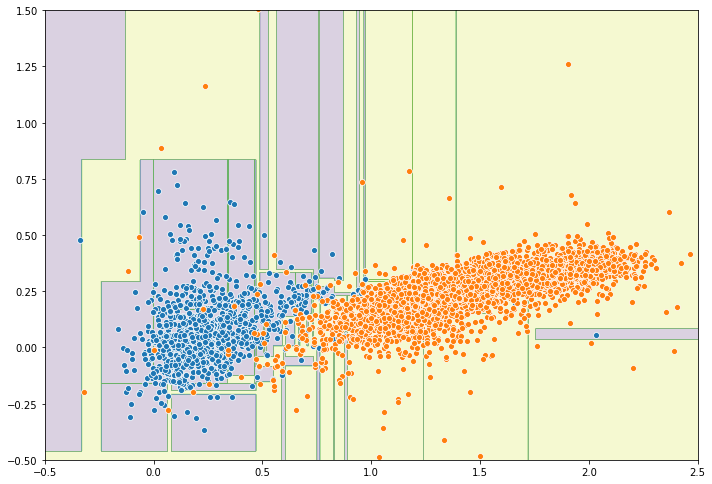

In [29]:
plot_decision_regions(X_train, y_train, DTclf, resolution=0.001, eps=0.1)

<img src="overfitting.png">

#### Regularization #2 - Reduce depth

In [30]:
DTclf = tree.DecisionTreeClassifier(max_depth=1, min_samples_split=40)
DTclf=DTclf.fit(X_train, y_train)

acc_dectree=score_res(DTclf, X_test, y_test, X, y, 10)



Accuracy from 1 test set: 0.9816 

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       367
           1       0.99      0.99      0.99      2133

    accuracy                           0.98      2500
   macro avg       0.96      0.97      0.96      2500
weighted avg       0.98      0.98      0.98      2500

Confusion_matrix:
[[ 348   19]
 [  27 2106]]

 k-fold cross validation with 10 folds: 
[0.98001998 0.98301698 0.98801199 0.983      0.974      0.982
 0.98       0.97797798 0.98198198 0.97697698]

 Accuracy: 0.98 (+/- 0.01)



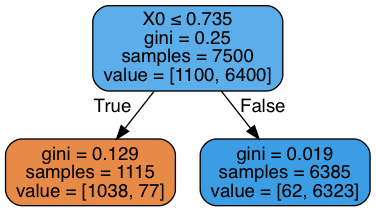

In [31]:
dot_data = StringIO()
export_graphviz(DTclf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

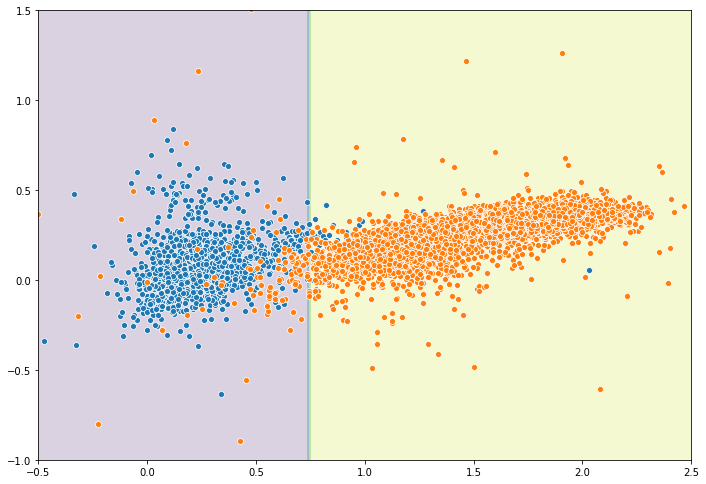

In [35]:
plot_decision_regions(X, y, DTclf, resolution=0.02, eps=0.1)

In [36]:
score_res(DTclf, X_train, y_train, X, y, 10)

Accuracy from 1 test set: 0.9814666666666667 

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1100
           1       0.99      0.99      0.99      6400

    accuracy                           0.98      7500
   macro avg       0.96      0.97      0.96      7500
weighted avg       0.98      0.98      0.98      7500

Confusion_matrix:
[[1038   62]
 [  77 6323]]

 k-fold cross validation with 10 folds: 
[0.98001998 0.98301698 0.98801199 0.983      0.974      0.982
 0.98       0.97797798 0.98198198 0.97697698]

 Accuracy: 0.98 (+/- 0.01)



0.9806985887985886

<hr style="border-width:2px;border-color:#75DFC1">
<h2 style = "text-align:center"> Advanced grid search </h2> 
<hr style="border-width:2px;border-color:#75DFC1">

> Make the above intuitions automatic, scalable, statistically more robust.
* automatic, scalable: with pipelines
* more robust: optimisze hyperparameters w. cross validation

> Cross-validation in sklearn:

* Hyperparameters are specified through a dictionary

```python

params = {
   'C': np.logspace(-5, 5, 50) # 50 values equally spaced in Log between 10**-5 and 10**5
    
}
```
* Initialize classifier
```python
logreg = LogisticRegression(solver='lbfgs', max_iter=500)
```
* Use GridSearchCV
```python
grid = GridSearchCV(logreg, params, verbose=0, cv=3,\
                    scoring=make_scorer(f1_score))
# note: refit=True by default
grid.fit(X_train, y_train).score(X_test, y_test)
```


> Pipeline in sklearn. Pipelines are useful to optimize over multiple hyperparameters
* Build the pipeline: List all transformations that we want to apply to our data. For each step, a tuple of 2 objects: (name, acual objet performing operation)

```python

steps = [
    ('scaler', MinMaxScaler()),
    ('pca', PCA()),
    ('rf', RandomForestClassifier())
]
pipeline = Pipeline(steps)
```

* When passing hyperparameters values, we should now specify which ones to use at each step
```python
params = {
    'pca__n_components': np.arange(1, 51, 5),
    'rf__n_estimators': np.arange(5, 55, 5)       
}
grid = GridSearchCV(pipeline, params, verbose=1)
```

* Fit

```python

grid.fit(X_train, y_train).score(X_test, y_test)

# Note: .fit method fits ALL the methods in steps !
```

* best params:
``` python
grid.best_params_
```

* Flexible! You can also optimize on methods , e.g.:
```python
params_1 = {
  'rf': [LogisticRegression(solver='lbfgs', max_iter=500)],
  'rf__C': np.logspace(-5,-5,10)
}
params_2 = {
  'rf': [RandomForestClassifier()],
  'rf__n_estimators': np.arange(5,55,5) 
}
grid = GridSearchCV(pipeline, [params_1, params_2], verbose=1)
grid.fit(X_train, y_train)
grid.best_score_
```

In [37]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV



def my_pipeline(my_clf, x_train, x_test , y_train, y_test, scorer, parameters):

    pipeline = Pipeline([('clf', my_clf)])

    nn = x_train.shape[0]

    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1,verbose=1, scoring=scorer)
    grid_search.fit(x_train, y_train)
    print ('Best score: %0.3f' % grid_search.best_score_)
    print ('Best parameters set:')
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print ('\t%s: %r' % (param_name, best_parameters[param_name]))

    predictions = grid_search.predict(x_test)
    print (classification_report(y_test, predictions))
    
    return grid_search

### Random forest + different metrics

<img src="metrics.png">

Precision : ability not to label as QSO something that is actually a galaxy

Recall: ability to find ALL QSO

f1: harmonic mean

In [38]:
from sklearn import ensemble

parameters_rf = {
        'clf__criterion': ('gini', 'entropy'),
        'clf__max_depth': (1, 2, 3, 5 ),
        'clf__min_samples_leaf':( 5, 10, 20),
    'clf__min_samples_split':(5, 10, 20)
    }

class_RF = my_pipeline(ensemble.RandomForestClassifier(n_jobs=-1, random_state=321),
                       X_train, X_test, y_train, y_test,
                       make_scorer(f1_score), parameters_rf )

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   16.5s finished


Best score: 0.991
Best parameters set:
	clf__criterion: 'gini'
	clf__max_depth: 5
	clf__min_samples_leaf: 5
	clf__min_samples_split: 5
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       367
           1       0.99      0.99      0.99      2133

    accuracy                           0.98      2500
   macro avg       0.97      0.96      0.96      2500
weighted avg       0.98      0.98      0.98      2500



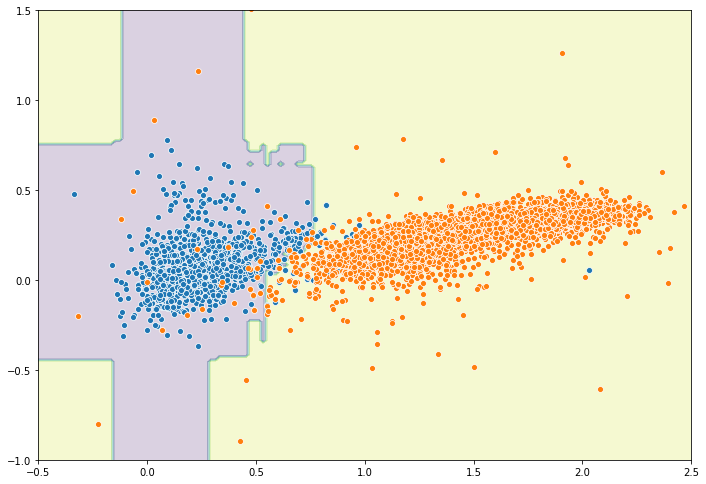

In [39]:
plot_decision_regions(X_train.to_numpy(), y_train.to_numpy(), class_RF, resolution=0.02, eps=0.1)

#### Change metric

In [41]:
class_RF_2 = my_pipeline(ensemble.RandomForestClassifier(n_jobs=-1, random_state=321),
                       X_train, X_test, y_train, y_test,
                       make_scorer(recall_score), parameters_rf )

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   12.7s finished


Best score: 0.993
Best parameters set:
	clf__criterion: 'gini'
	clf__max_depth: 2
	clf__min_samples_leaf: 5
	clf__min_samples_split: 5
              precision    recall  f1-score   support

           0       0.95      0.62      0.75       367
           1       0.94      0.99      0.97      2133

    accuracy                           0.94      2500
   macro avg       0.94      0.81      0.86      2500
weighted avg       0.94      0.94      0.93      2500



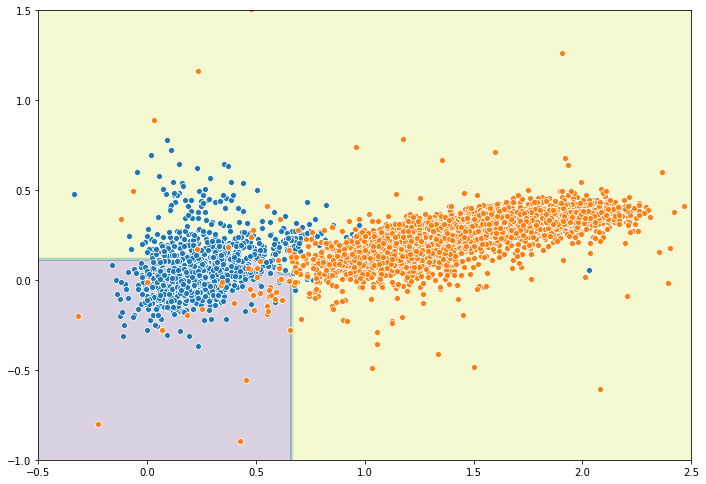

In [42]:
plot_decision_regions(X_train, y_train, class_RF_2, resolution=0.02, eps=0.1)

In [43]:
class_RF_3 = my_pipeline(ensemble.RandomForestClassifier(n_jobs=-1, random_state=321),
                       X_train, X_test, y_train, y_test,
                       make_scorer(precision_score), parameters_rf )

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   13.3s finished


Best score: 0.990
Best parameters set:
	clf__criterion: 'entropy'
	clf__max_depth: 3
	clf__min_samples_leaf: 10
	clf__min_samples_split: 5
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       367
           1       0.99      0.99      0.99      2133

    accuracy                           0.98      2500
   macro avg       0.96      0.96      0.96      2500
weighted avg       0.98      0.98      0.98      2500



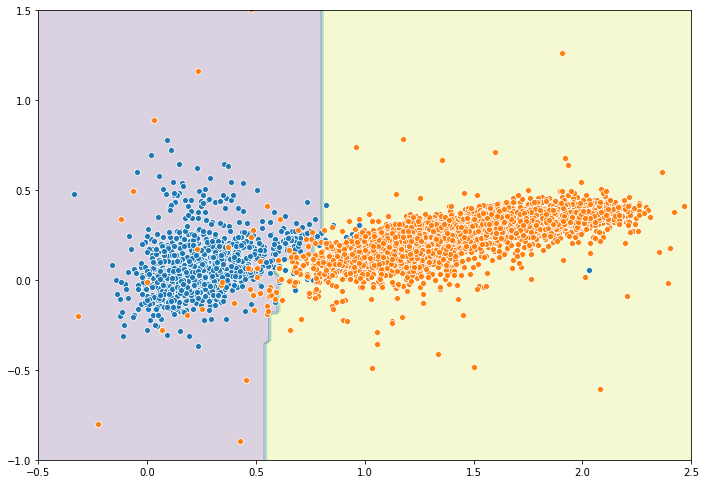

In [44]:
plot_decision_regions(X_train, y_train, class_RF_3, resolution=0.02, eps=0.1)

#### Custom metric

Define a function thath specifies your metric and returns the score. Then pass it to the pipeline using make_scorer

In [57]:
# Actually useful for multi class problems: precision/recall on specific subclass

def custom_metric(y_true, y_pred): 
    ''' Computes Mean '''
    rec = recall_score(y_true, y_pred)
    prec=precision_score(y_true, y_pred)
    return np.sqrt(rec*prec)

my_scorer = make_scorer(custom_metric)



In [58]:
class_RF_1 = my_pipeline(ensemble.RandomForestClassifier(n_jobs=-1, random_state=321),
                       X_train, X_test, y_train, y_test,
                       my_scorer, parameters_rf )

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   13.3s finished


Best score: 0.991
Best parameters set:
	clf__criterion: 'gini'
	clf__max_depth: 5
	clf__min_samples_leaf: 5
	clf__min_samples_split: 5
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       367
           1       0.99      0.99      0.99      2133

    accuracy                           0.98      2500
   macro avg       0.97      0.96      0.96      2500
weighted avg       0.98      0.98      0.98      2500



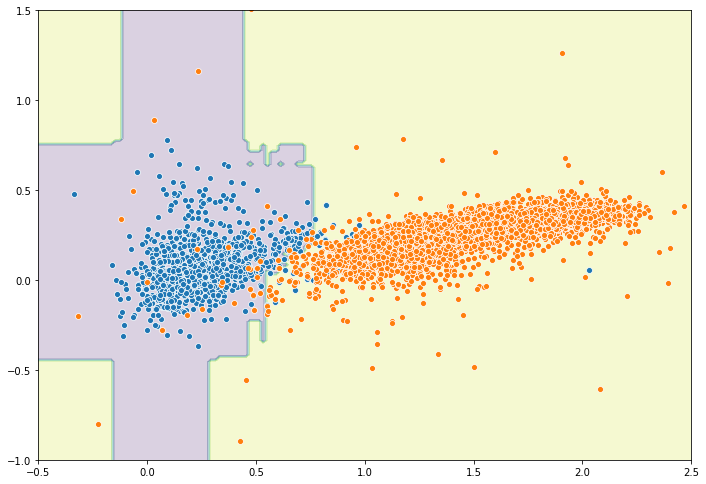

In [59]:
plot_decision_regions(X_train, y_train, class_RF_1, resolution=0.02, eps=0.1)

### SVM

#### Linear boudaries - example: poor evaluation metric!

In [62]:
## 2. SVM
# http://scikit-learn.org/stable/modules/svm.html#svm-classification

from sklearn import svm

parameters_SVM_1 = {'clf__kernel': ['poly', 'linear'],
         'clf__C': [1, 0.1, 0.01],
          'clf__gamma': [ 0.01, 0.1, 1],
          }

SVMbest_1=my_pipeline(svm.SVC( class_weight='balanced'),
                       X_train, X_test, y_train, y_test,
                       make_scorer(precision_score) , parameters_SVM_1 )


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    8.9s finished


Best score: 0.994
Best parameters set:
	clf__C: 1
	clf__gamma: 0.1
	clf__kernel: 'poly'
              precision    recall  f1-score   support

           0       0.68      0.97      0.80       367
           1       0.99      0.92      0.96      2133

    accuracy                           0.93      2500
   macro avg       0.84      0.95      0.88      2500
weighted avg       0.95      0.93      0.93      2500



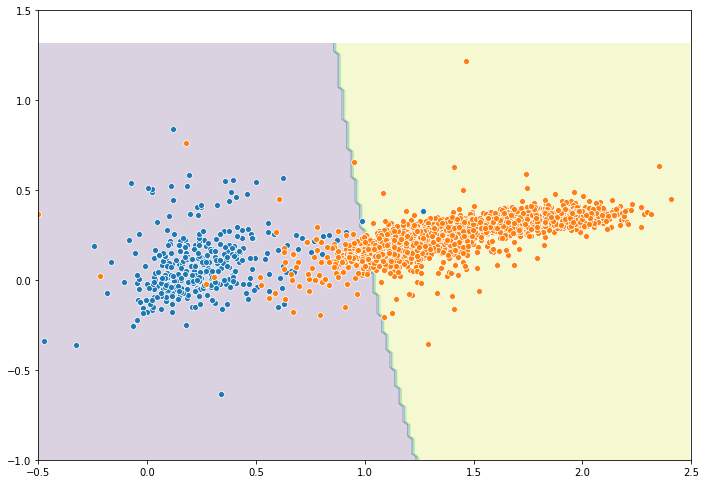

In [63]:
plot_decision_regions(X_test.to_numpy(), y_test.to_numpy(), SVMbest_1, resolution=0.02, eps=0.1)

> According to our metric, this is almost the **perfect** classifier!! (looking for max fraction of quasars correcly identified as quasars)

In [64]:


SVMbest_2=my_pipeline(svm.SVC( class_weight='balanced'),
                       X_train, X_test, y_train, y_test,
                       make_scorer(f1_score), parameters_SVM_1 )


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   10.5s finished


Best score: 0.988
Best parameters set:
	clf__C: 1
	clf__gamma: 0.01
	clf__kernel: 'linear'
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       367
           1       0.99      0.98      0.99      2133

    accuracy                           0.98      2500
   macro avg       0.95      0.97      0.96      2500
weighted avg       0.98      0.98      0.98      2500



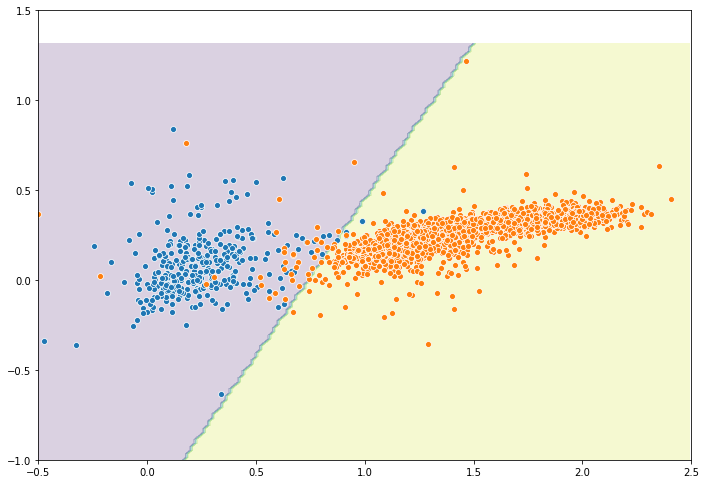

In [65]:
plot_decision_regions(X_test.to_numpy(), y_test.to_numpy(), SVMbest_2, resolution=0.02, eps=0.1)

#### Non Linear boudaries

To do better I might need to draw more complex boundaries

In [66]:


parameters_SVM = {'clf__kernel': ['rbf'],
         'clf__C': [0.01,1, 0.5, 0.1],
          'clf__gamma': [  0.01, 0.1,1, 5],
          }

In [75]:
SVMbest_3=my_pipeline(svm.SVC( class_weight='balanced'),
                       X_train, X_test, y_train, y_test,
                       make_scorer(recall_score), parameters_SVM )

#acc_svc=score_res(SVMbest, X_test, y_test,X, y 10)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    8.3s finished


Best score: 0.986
Best parameters set:
	clf__C: 1
	clf__gamma: 1
	clf__kernel: 'rbf'
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       367
           1       0.99      0.99      0.99      2133

    accuracy                           0.98      2500
   macro avg       0.96      0.97      0.96      2500
weighted avg       0.98      0.98      0.98      2500



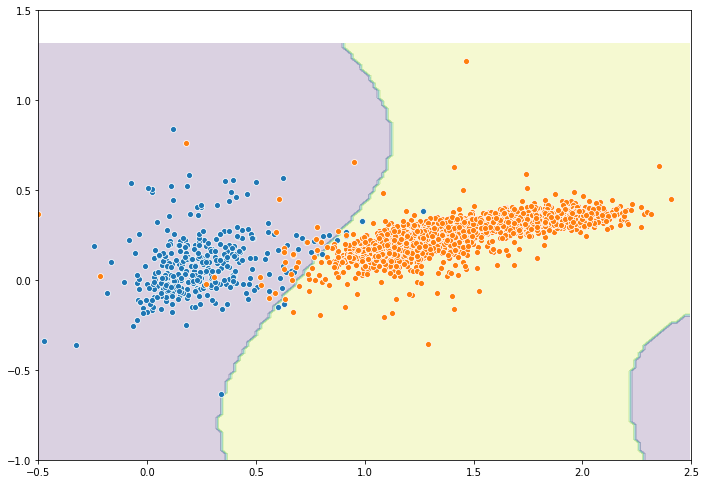

In [76]:
plot_decision_regions(X_test.to_numpy(), y_test.to_numpy(), SVMbest_3, resolution=0.02, eps=0.1)

In [73]:
SVMbest_4=my_pipeline(svm.SVC( class_weight='balanced'),
                       X_train, X_test, y_train, y_test,
                       make_scorer(precision_score), parameters_SVM )

#acc_svc=score_res(SVMbest, X_test, y_test,X, y 10)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    9.0s finished


Best score: 0.993
Best parameters set:
	clf__C: 0.1
	clf__gamma: 5
	clf__kernel: 'rbf'
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       367
           1       0.99      0.98      0.99      2133

    accuracy                           0.98      2500
   macro avg       0.95      0.97      0.96      2500
weighted avg       0.98      0.98      0.98      2500



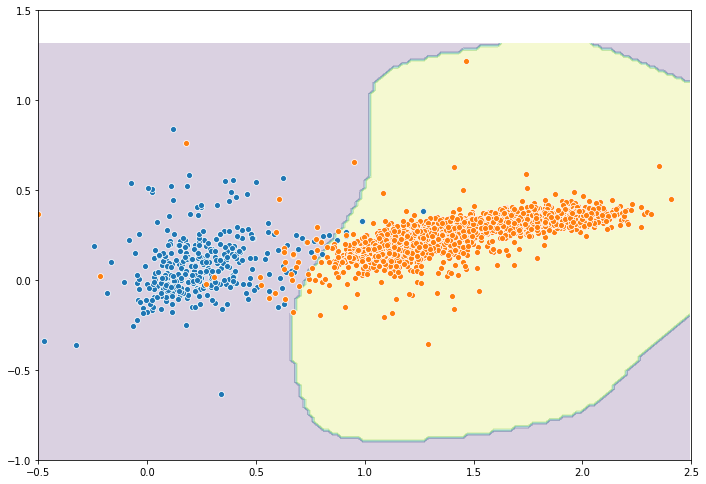

In [74]:
plot_decision_regions(X_test.to_numpy(), y_test.to_numpy(), SVMbest_4, resolution=0.02, eps=0.1)

#### Play with metrics

In [82]:
def custom_recall_1(y_true, y_pred): 
    ''' Computes recall only on labels 0 '''
    rec = recall_score(y_true, y_pred, pos_label=0, average='binary')
    return rec #target_accuracy

my_scorer_1 = make_scorer(custom_recall_1)

# fraction of galaxies correctly classified as galaxies : (true galaxies correcly classified)/(true galaxies correcly classified + quasars misclassified as galaxies)

In [83]:
SVMbest_5=my_pipeline(svm.SVC( class_weight='balanced'),
                       X_train, X_test, y_train, y_test,
                       my_scorer_1, parameters_SVM )

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   10.0s finished


Best score: 0.969
Best parameters set:
	clf__C: 0.01
	clf__gamma: 0.01
	clf__kernel: 'rbf'
              precision    recall  f1-score   support

           0       0.68      0.97      0.80       367
           1       0.99      0.92      0.96      2133

    accuracy                           0.93      2500
   macro avg       0.84      0.95      0.88      2500
weighted avg       0.95      0.93      0.93      2500



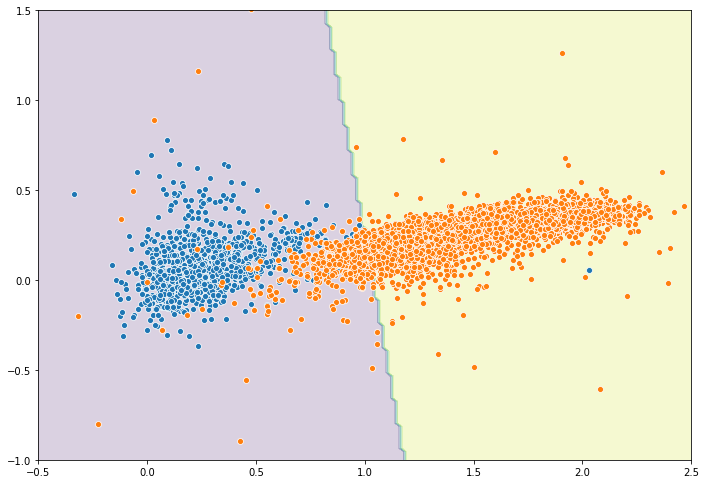

In [84]:
plot_decision_regions(X_train.to_numpy(), y_train.to_numpy(), SVMbest_5, resolution=0.02, eps=0.1)

In [85]:
def custom_precision(y_true, y_pred): 
    ''' Computes recall only on labels 0 '''
    rec = precision_score(y_true, y_pred, pos_label=0, average='binary')
    return rec #target_accuracy

my_scorer_2 = make_scorer(custom_precision)

# Maximise fraction of (correctly classified  galaxies)/(all classified as galaxies) 

In [86]:
SVMbest_6 = my_pipeline(svm.SVC(),
                       X_train, X_test, y_train, y_test,
                       my_scorer_2, parameters_SVM )


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    4.7s finished


Best score: 0.970
Best parameters set:
	clf__C: 0.01
	clf__gamma: 0.1
	clf__kernel: 'rbf'
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       367
           1       0.97      1.00      0.98      2133

    accuracy                           0.97      2500
   macro avg       0.97      0.92      0.94      2500
weighted avg       0.97      0.97      0.97      2500



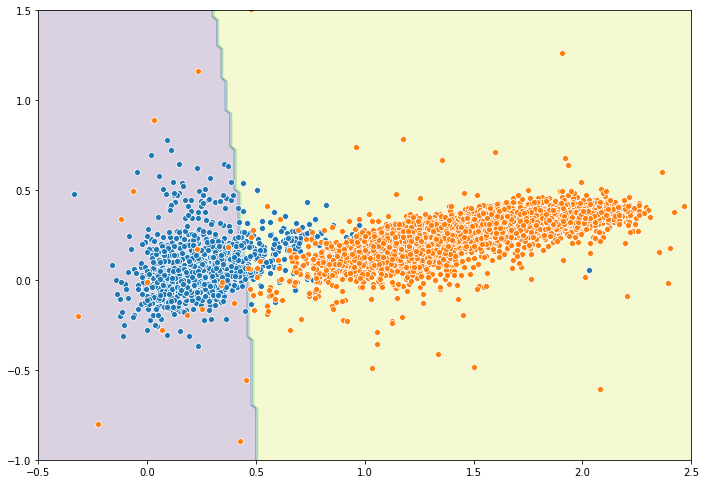

In [87]:
plot_decision_regions(X_train.to_numpy(), y_train.to_numpy(), SVMbest_6, resolution=0.02, eps=0.1)

#### KNN

In [88]:
from sklearn.neighbors import KNeighborsClassifier


parameters_KNN = {'clf__n_neighbors': [1, 5, 10, 20, 100],
                  'clf__metric': ['euclidean', 'manhattan', 'chebyshev']
          }

KNN_best_1=my_pipeline(KNeighborsClassifier(),
                       X_train, X_test, y_train, y_test,
                       my_scorer , parameters_KNN )



Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.991
Best parameters set:
	clf__metric: 'manhattan'
	clf__n_neighbors: 5
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       367
           1       0.99      0.99      0.99      2133

    accuracy                           0.98      2500
   macro avg       0.97      0.96      0.96      2500
weighted avg       0.98      0.98      0.98      2500



[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    4.0s finished


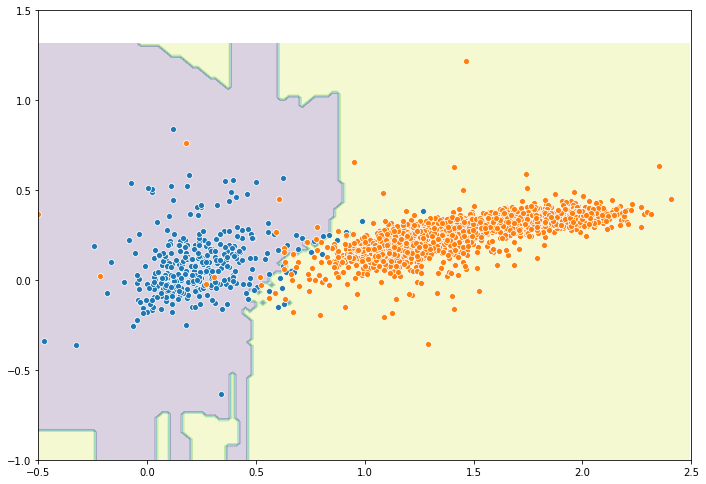

In [89]:
plot_decision_regions(X_test.to_numpy(), y_test.to_numpy(), KNN_best_1, resolution=0.02, eps=0.1)

In [90]:
KNN_best_2=my_pipeline(KNeighborsClassifier(),
                       X_train, X_test, y_train, y_test,
                       make_scorer(f1_score) , parameters_KNN )


Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.991
Best parameters set:
	clf__metric: 'manhattan'
	clf__n_neighbors: 5
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       367
           1       0.99      0.99      0.99      2133

    accuracy                           0.98      2500
   macro avg       0.97      0.96      0.96      2500
weighted avg       0.98      0.98      0.98      2500



[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    4.6s finished


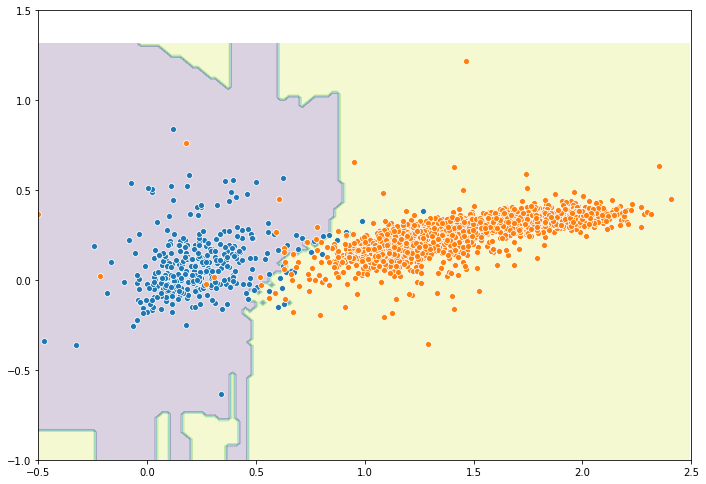

In [91]:
plot_decision_regions(X_test.to_numpy(), y_test.to_numpy(), KNN_best_2, resolution=0.02, eps=0.1)

In [92]:
KNN_best_3=my_pipeline(KNeighborsClassifier(),
                       X_train, X_test, y_train, y_test,
                       make_scorer(precision_score)  , parameters_KNN )


Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.991
Best parameters set:
	clf__metric: 'manhattan'
	clf__n_neighbors: 20
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       367
           1       0.99      0.99      0.99      2133

    accuracy                           0.98      2500
   macro avg       0.97      0.96      0.96      2500
weighted avg       0.98      0.98      0.98      2500



[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    4.4s finished


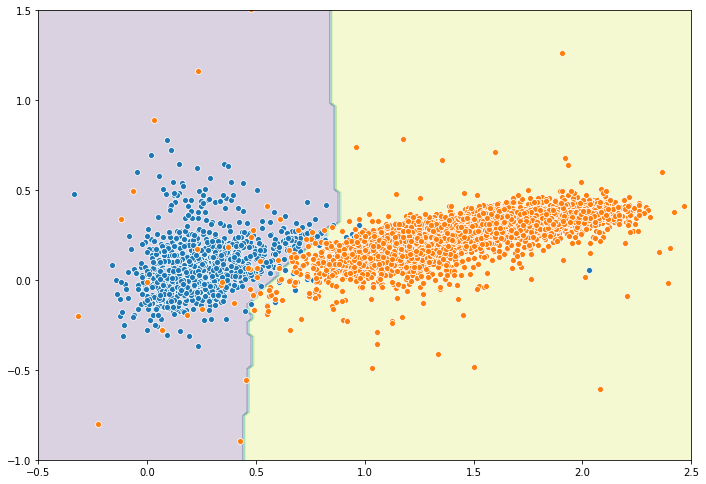

In [93]:
plot_decision_regions(X_train.to_numpy(), y_train.to_numpy(), KNN_best_3, resolution=0.02, eps=0.1)

<hr style="border-width:2px;border-color:#75DFC1">
<h2 style = "text-align:center"> Summary and take away message </h2> 
<hr style="border-width:2px;border-color:#75DFC1">


> Cross-validation and hyperparameter tuning: do it!

> Metric is crucial and subjective: depends on your goals and what kind of error you want to penalise more

> Different algorithms according to the king of boudary (e.g. choice of kernels for nonlinear problems)

> sklearn-related: use pipelines + gridsearchCV 